# Capstone Project - The Battle of the Neighborhoods (Week 2)

## Introduction: Business Problem

Bangkok is the capital city of Thailand with a population of over 10 million. Bangkok is the top 7th city in Asia from World’s Best Awards survey, Travel + Leisure. Bangkok is a city that attracts investors who want to invest in Thailand. Specially, we will focus on restuarant and food service industry. 

The purpose of this project is to **help entrepreneurs for exploring ideas and cuisine styles** for opening a restaurant. Specifically, this project will be targeted at stakeholders interested in opening a restaurant in **Bangkok**, Thailand. 

It will help people making **smart and efficient decisions** on selecting a great district and cuisine style for opening a restaurant in Bangkok.

Along the line of Business Strategies, it was decided that the **Unsupervised Machine Learning** technique could be applied to analyze and uncover insights valuable to influencing the formulation of the Client’s business strategies. Specifically, **K-Means clustering** will be applied onto the relevant restaurants’ geospatial data to cluster these entities and uncover insights such as viable restaurant themes and suitable restaurant locations.



## Data Description

Data Link: https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok

We will use the list of districts of Bangkok data, which contains the list of districts, map nr, post-code, district's name in Thai, population, no. of sub-districts, latitude and longitude. 

We will need data about different venues in different districts. In order to gain that information we will use "Foursquare" locational information. Foursquare is a location data provider with information about all manner of venues and events within an area of interest. Such information includes venue names, locations, menus and even photos. As such, the foursquare location platform will be used as the sole data source since all the stated required information can be obtained through the API.

After finding the list of districts, we then connect to the Foursquare API to gather information about venues inside each and every district. For each district, we have chosen the radius to be 1000 meter.

The data retrieved from Foursquare contained information of venues within a specified distance of the longitude and latitude of the postcodes. The information obtained per venue as follows:

1. Districts
2. District's Latitude
3. District's Longitude
4. Venues
5. Name of the venue e.g. the name of a store or restaurant
6. Venue's Latitude
7. Venue's Longitude
8. Venue's Category

### Importing all the required libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from sklearn.metrics import silhouette_score

import seaborn as sns

print('Libraries imported.')

Libraries imported.


### Scrape data from HTML table into a DataFrame using read_html

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok"
wiki_url = requests.get(url)
wiki_url

<Response [200]>

Response 200 means that we are able to make the connection to the page.

In [3]:
wiki_data = pd.read_html(wiki_url.text)
wiki_data

[          District(Khet)  MapNr  Post-code               Thai  Popu-lation  \
 0               Bang Bon     50      10150             บางบอน       105161   
 1              Bang Kapi      6      10240            บางกะปิ       148465   
 2              Bang Khae     40      10160              บางแค       191781   
 3              Bang Khen      5      10220             บางเขน       189539   
 4          Bang Kho Laem     31      10120          บางคอแหลม        94956   
 5        Bang Khun Thian     21      10150        บางขุนเทียน       165491   
 6                Bang Na     47      10260              บางนา        95912   
 7             Bang Phlat     25      10700            บางพลัด        99273   
 8               Bang Rak      4      10500             บางรัก        45875   
 9               Bang Sue     29      10800            บางซื่อ       132234   
 10           Bangkok Noi     20      10700         บางกอกน้อย       117793   
 11           Bangkok Yai     16      10600         

In [4]:
# Show the top 5 data
bangkok_dist = wiki_data[0]
bangkok_dist.head()

,District(Khet),MapNr,Post-code,Thai,Popu-lation,No. ofSubdis-trictsKhwaeng,Latitude,Longitude
0,Bang Bon,50,10150,บางบอน,105161,4,13.659200,100.399100
1,Bang Kapi,6,10240,บางกะปิ,148465,2,13.765833,100.647778
2,Bang Khae,40,10160,บางแค,191781,4,13.696111,100.409444
3,Bang Khen,5,10220,บางเขน,189539,2,13.873889,100.596389
4,Bang Kho Laem,31,10120,บางคอแหลม,94956,3,13.693333,100.502500


In [5]:
# Check data type
bangkok_dist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   District(Khet)              50 non-null     object 
 1   MapNr                       50 non-null     int64  
 2   Post-code                   50 non-null     int64  
 3   Thai                        50 non-null     object 
 4   Popu-lation                 50 non-null     int64  
 5   No. ofSubdis-trictsKhwaeng  50 non-null     int64  
 6   Latitude                    50 non-null     float64
 7   Longitude                   50 non-null     float64
dtypes: float64(2), int64(4), object(2)
memory usage: 3.2+ KB


In [6]:
# Drop the unused columns
bangkok_dist.drop(['MapNr', 'Thai','No. ofSubdis-trictsKhwaeng'], axis = 1, inplace = True)
bangkok_dist.head()

,District(Khet),Post-code,Popu-lation,Latitude,Longitude
0,Bang Bon,10150,105161,13.659200,100.399100
1,Bang Kapi,10240,148465,13.765833,100.647778
2,Bang Khae,10160,191781,13.696111,100.409444
3,Bang Khen,10220,189539,13.873889,100.596389
4,Bang Kho Laem,10120,94956,13.693333,100.502500


In [7]:
# Rename the District column
bangkok_dist = bangkok_dist.rename({'District(Khet)': 'District'}, axis=1)
bangkok_dist.head()

,District,Post-code,Popu-lation,Latitude,Longitude
0,Bang Bon,10150,105161,13.659200,100.399100
1,Bang Kapi,10240,148465,13.765833,100.647778
2,Bang Khae,10160,191781,13.696111,100.409444
3,Bang Khen,10220,189539,13.873889,100.596389
4,Bang Kho Laem,10120,94956,13.693333,100.502500


In [8]:
# Show top 25 most population in each district
bangkok_dist_sort = bangkok_dist.sort_values(by = 'Popu-lation', ascending =False)
bangkok_dist_sort = bangkok_dist_sort.reset_index()
bangkok_dist_sort = bangkok_dist_sort.drop(['index'], axis = 1)
# Reset the index, start from 1
bangkok_dist_sort.index = np.arange(1, len(bangkok_dist_sort)+1)
bangkok_dist_sort.head(25)

,District,Post-code,Popu-lation,Latitude,Longitude
1,Bang Khae,10160,191781,13.696111,100.409444
2,Bang Khen,10220,189539,13.873889,100.596389
3,Sai Mai,10220,188123,13.919167,100.645833
4,Khlong Sam Wa,10510,169489,13.859722,100.704167
5,Don Mueang,10210,166261,13.913611,100.589722
6,Bang Khun Thian,10150,165491,13.660833,100.435833
7,Lat Krabang,10520,163175,13.722317,100.759669
8,Chatuchak,10900,160906,13.828611,100.559722
9,Prawet,10250,160671,13.716944,100.694444
10,Chom Thong,10150,158005,13.677222,100.484722


We can see that Bang Khea has the most population, followed by Bang Khen and Sai Mai.

#### Plot the number of population in each district

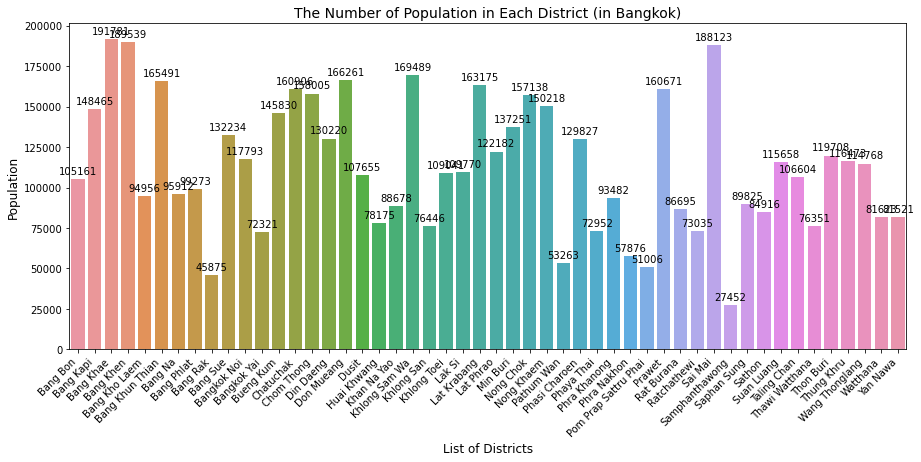

In [9]:
fig = plt.figure(figsize=(15,6))
fig = sns.barplot(x='District',y='Popu-lation',data=bangkok_dist)
plt.title('The Number of Population in Each District (in Bangkok)', fontsize=14)
plt.xlabel("List of Districts", fontsize=12)
plt.ylabel ("Population", fontsize=12)
plt.xticks(rotation=45,  horizontalalignment='right')

for bar in fig.patches:
    # passing the coordinates where the annotation shall be done
    # x-coordinate: bar.get_x() + bar.get_width() / 2
    # y-coordinate: bar.get_height()
    # free space to be left to make graph pleasing: (0, 8)
    # ha and va stand for the horizontal and vertical alignment
    fig.annotate(format(bar.get_height(), '.0f'), 
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', 
                 va='center',
                 size=10, xytext=(0, 8),
                 textcoords='offset points')

plt.show()

#### Use geopy library to get the latitude and longitude values of Bangkok City.

In [10]:
address = 'Thailand, Bangkok'

geolocator = Nominatim(user_agent="bangkok_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bangkok City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bangkok City are 13.7544238, 100.4930399.


#### Create a map of Bangkok with districts superimposed on top.

In [11]:
# create map of Bangkok using latitude and longitude values
map_bangkok = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, dist in zip(bangkok_dist['Latitude'], bangkok_dist['Longitude'], bangkok_dist['District']):
    label = '{}'.format(dist)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bangkok)  
    
map_bangkok

### Explore districts in Bangkok

#### Define Foursquare Credentials and Version

In [12]:
CLIENT_ID = 'T4D4KTRB3XA10TZMHRYNYHRUAU1CQ3GQDLLKLXJ2Y2AYWM0S' # your Foursquare ID
CLIENT_SECRET = 'S4MNJYEALOWL0Q2AC2Q2SJ1XPVE44MT20NDSOLN3TAZRUPJV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: T4D4KTRB3XA10TZMHRYNYHRUAU1CQ3GQDLLKLXJ2Y2AYWM0S
CLIENT_SECRET:S4MNJYEALOWL0Q2AC2Q2SJ1XPVE44MT20NDSOLN3TAZRUPJV


#### Let's create a function to repeat the same process to all the districts in Bangkok

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each districts and create a new dataframe called _bangkok_venues_.

In [14]:
bangkok_venues = getNearbyVenues(names=bangkok_dist['District'],
                                   latitudes=bangkok_dist['Latitude'],
                                   longitudes=bangkok_dist['Longitude']
                                  )

Bang Bon
Bang Kapi
Bang Khae
Bang Khen
Bang Kho Laem
Bang Khun Thian
Bang Na
Bang Phlat
Bang Rak
Bang Sue
Bangkok Noi
Bangkok Yai
Bueng Kum
Chatuchak
Chom Thong
Din Daeng
Don Mueang
Dusit
Huai Khwang
Khan Na Yao
Khlong Sam Wa
Khlong San
Khlong Toei
Lak Si
Lat Krabang
Lat Phrao
Min Buri
Nong Chok
Nong Khaem
Pathum Wan
Phasi Charoen
Phaya Thai
Phra Khanong
Phra Nakhon
Pom Prap Sattru Phai
Prawet
Rat Burana
Ratchathewi
Sai Mai
Samphanthawong
Saphan Sung
Sathon
Suan Luang
Taling Chan
Thawi Watthana
Thon Buri
Thung Khru
Wang Thonglang
Watthana
Yan Nawa


In [15]:
# Check the size of the dataframe
print(bangkok_venues.shape)
bangkok_venues.head(20)

(2887, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bang Bon,13.6592,100.3991,ขาหมูบางหว้า,13.657136,100.395230,Thai Restaurant
1,Bang Bon,13.6592,100.3991,Irashaimase Japanese Restaurant,13.658358,100.401403,Japanese Restaurant
2,Bang Bon,13.6592,100.3991,ร้านต้นไม้ ริมถนนกาญจนาภิเษก,13.654098,100.405054,Garden Center
3,Bang Bon,13.6592,100.3991,ส.สุขโภชนา,13.660358,100.404866,Chinese Restaurant
4,Bang Bon,13.6592,100.3991,เจ๊ไน้ ก๋วยเตี๋ยวเป็ดตุ๋น,13.654137,100.405323,Noodle House
5,Bang Bon,13.6592,100.3991,Lotus Express (โลตัส เอ็กซ์เพรส),13.657839,100.397243,Convenience Store
6,Bang Bon,13.6592,100.3991,ทิพวรรณโอชา ก๋วยเตี๋ยวเนื้อตุ๋น,13.654004,100.405454,Noodle House
7,Bang Bon,13.6592,100.3991,Bussabar Steak House,13.656856,100.404690,Bar
8,Bang Bon,13.6592,100.3991,7-Eleven (เซเว่น อีเลฟเว่น),13.656440,100.394178,Convenience Store
9,Bang Bon,13.6592,100.3991,7-Eleven,13.664457,100.405074,Convenience Store


We need only the **restaurant and noodle house category**, so we extract the restaurant and noodle house category from _bangkok_venues_.

In [16]:
bangkok_venues_restr = bangkok_venues[bangkok_venues['Venue Category'].str.contains('Restaurant|Noodle')].reset_index(drop=True)
# set index to start from 1
bangkok_venues_restr.index = np.arange(1, len(bangkok_venues_restr)+1)
bangkok_venues_restr.head(20)

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Bang Bon,13.659200,100.399100,ขาหมูบางหว้า,13.657136,100.395230,Thai Restaurant
2,Bang Bon,13.659200,100.399100,Irashaimase Japanese Restaurant,13.658358,100.401403,Japanese Restaurant
3,Bang Bon,13.659200,100.399100,ส.สุขโภชนา,13.660358,100.404866,Chinese Restaurant
4,Bang Bon,13.659200,100.399100,เจ๊ไน้ ก๋วยเตี๋ยวเป็ดตุ๋น,13.654137,100.405323,Noodle House
5,Bang Bon,13.659200,100.399100,ทิพวรรณโอชา ก๋วยเตี๋ยวเนื้อตุ๋น,13.654004,100.405454,Noodle House
6,Bang Bon,13.659200,100.399100,ลาบร้อยเอ็ด เสือเคหะ,13.656436,100.404455,Som Tum Restaurant
7,Bang Bon,13.659200,100.399100,ส.ทิพรส,13.659368,100.399382,Noodle House
8,Bang Bon,13.659200,100.399100,บ้านพลูหลวง เอกชัย,13.658482,100.398440,Asian Restaurant
9,Bang Bon,13.659200,100.399100,ก๋วยเตี๋ยวปลา แม่ช้อนทอง,13.657938,100.396723,Noodle House
10,Bang Bon,13.659200,100.399100,ชามทอง ลูกชิ้นหมู ก๋วยเตี๋ยวหมูต้มยำ (สุธารส (...,13.655427,100.393147,Noodle House


In [43]:
# Remove vanue catagory = Restaurant, because we dont know what is exactly type of the restaurant is
bangkok_venues_restr = bangkok_venues_restr[bangkok_venues_restr['Venue Category'] != 'Restaurant']
bangkok_venues_restr.head(10)

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Bang Bon,13.6592,100.3991,ขาหมูบางหว้า,13.657136,100.395230,Thai Restaurant
2,Bang Bon,13.6592,100.3991,Irashaimase Japanese Restaurant,13.658358,100.401403,Japanese Restaurant
3,Bang Bon,13.6592,100.3991,ส.สุขโภชนา,13.660358,100.404866,Chinese Restaurant
4,Bang Bon,13.6592,100.3991,เจ๊ไน้ ก๋วยเตี๋ยวเป็ดตุ๋น,13.654137,100.405323,Noodle House
5,Bang Bon,13.6592,100.3991,ทิพวรรณโอชา ก๋วยเตี๋ยวเนื้อตุ๋น,13.654004,100.405454,Noodle House
6,Bang Bon,13.6592,100.3991,ลาบร้อยเอ็ด เสือเคหะ,13.656436,100.404455,Som Tum Restaurant
7,Bang Bon,13.6592,100.3991,ส.ทิพรส,13.659368,100.399382,Noodle House
8,Bang Bon,13.6592,100.3991,บ้านพลูหลวง เอกชัย,13.658482,100.398440,Asian Restaurant
9,Bang Bon,13.6592,100.3991,ก๋วยเตี๋ยวปลา แม่ช้อนทอง,13.657938,100.396723,Noodle House
10,Bang Bon,13.6592,100.3991,ชามทอง ลูกชิ้นหมู ก๋วยเตี๋ยวหมูต้มยำ (สุธารส (...,13.655427,100.393147,Noodle House


In [18]:
# Print the types of restaurant in Bangkok
print(f"Types of restaurants in bangkok: {len(bangkok_venues_restr['Venue Category'].unique())}")

Types of restaurants in bangkok: 35


In [19]:
# create a dataframe with the venue category and counts
df_counts = bangkok_venues_restr['Venue Category'].value_counts().to_frame(name='counts')
df_counts = df_counts.reset_index()
df_counts.rename(index=str, columns={"index": "venue_category"}, inplace=True)
df_counts

,venue_category,counts
0,Noodle House,289
1,Thai Restaurant,215
2,Asian Restaurant,88
3,Japanese Restaurant,78
4,Chinese Restaurant,70
5,Som Tum Restaurant,55
6,Seafood Restaurant,49
7,Fast Food Restaurant,45
8,Hotpot Restaurant,44
9,Shabu-Shabu Restaurant,28


In [20]:
bangkok_venues_restr.groupby(['District'])['Venue Category'].apply(lambda x: x[x.str.contains('Restaurant|Noodle')].count()).sort_values()

District
Bueng Kum                1
Khlong Toei              2
Min Buri                 2
Nong Khaem               3
Prawet                   5
Nong Chok                5
Chom Thong               6
Bang Phlat               7
Sai Mai                  7
Don Mueang               8
Thawi Watthana           8
Bang Khae               10
Bang Na                 10
Din Daeng               11
Bang Bon                11
Taling Chan             15
Khlong Sam Wa           15
Thon Buri               17
Lak Si                  17
Thung Khru              18
Lat Krabang             18
Saphan Sung             19
Bangkok Noi             20
Bangkok Yai             21
Phasi Charoen           21
Bang Khun Thian         22
Phra Khanong            22
Bang Kho Laem           23
Wang Thonglang          24
Bang Khen               25
Lat Phrao               29
Rat Burana              29
Phra Nakhon             29
Ratchathewi             30
Khan Na Yao             30
Suan Luang              31
Pom Prap Sattru Pha

It appears Bang Kapi, Sathon, Bang Rak, Pathum Wan, Yan Nawa and Huai Khwang have higher density of restuarants (more than 40 in its area).

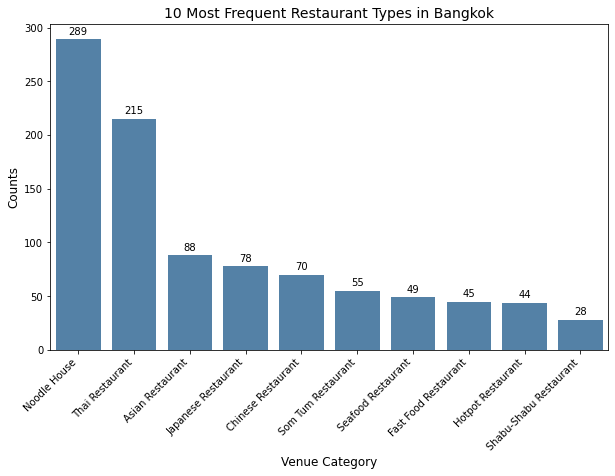

In [21]:
fig = plt.figure(figsize=(10,6))
fig = sns.barplot(x='venue_category',y='counts',data=df_counts[0:10],color='steelblue')
plt.title('10 Most Frequent Restaurant Types in Bangkok', fontsize=14)
plt.xlabel("Venue Category", fontsize=12)
plt.ylabel ("Counts", fontsize=12)
plt.xticks(rotation=45,  horizontalalignment='right')

for bar in fig.patches:
    # passing the coordinates where the annotation shall be done
    # x-coordinate: bar.get_x() + bar.get_width() / 2
    # y-coordinate: bar.get_height()
    # free space to be left to make graph pleasing: (0, 8)
    # ha and va stand for the horizontal and vertical alignment
    fig.annotate(format(bar.get_height(), '.0f'), 
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', 
                 va='center',
                 size=10, xytext=(0, 8),
                 textcoords='offset points')

plt.show()

The most frequent type is Noodle House.

### Analyze Each Neighborhood

In [22]:
# one hot encoding
bangkok_onehot = pd.get_dummies(bangkok_venues_restr[['Venue Category']], prefix="", prefix_sep="")

# add District column back to dataframe
bangkok_onehot['District'] = bangkok_venues_restr['District'] 

# move District column to the first column
fixed_columns = [bangkok_onehot.columns[-1]] + list(bangkok_onehot.columns[:-1])
bangkok_onehot = bangkok_onehot[fixed_columns]

bangkok_onehot.head()

,District,American Restaurant,Asian Restaurant,Cantonese Restaurant,Chinese Restaurant,Dim Sum Restaurant,Donburi Restaurant,Dumpling Restaurant,Fast Food Restaurant,French Restaurant,German Restaurant,Hainan Restaurant,Halal Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Korean Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Noodle House,Ramen Restaurant,Satay Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Som Tum Restaurant,Sushi Restaurant,Thai Restaurant,Tonkatsu Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
1,Bang Bon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,Bang Bon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bang Bon,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Bang Bon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,Bang Bon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
# check dataframe shape
print(f'new dataframe has {bangkok_onehot.shape[0]} rows, {bangkok_onehot.shape[1]} columns')

new dataframe has 1111 rows, 36 columns


#### Group rows by district and take the mean of the frequency of occurrence of each restaurant category

In [24]:
bangkok_grouped = bangkok_onehot.groupby('District').mean().reset_index()
bangkok_grouped.head(10)

,District,American Restaurant,Asian Restaurant,Cantonese Restaurant,Chinese Restaurant,Dim Sum Restaurant,Donburi Restaurant,Dumpling Restaurant,Fast Food Restaurant,French Restaurant,German Restaurant,Hainan Restaurant,Halal Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Korean Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Noodle House,Ramen Restaurant,Satay Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Som Tum Restaurant,Sushi Restaurant,Thai Restaurant,Tonkatsu Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Bang Bon,0.0,0.090909,0.000000,0.090909,0.0,0.000000,0.000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.090909,0.000,0.0,0.0,0.000000,0.454545,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.181818,0.000000,0.0,0.0,0.000000
1,Bang Kapi,0.0,0.000000,0.000000,0.025000,0.0,0.000000,0.025,0.100000,0.000000,0.0,0.0,0.000000,0.075000,0.000000,0.0,0.0,0.025,0.150000,0.025,0.0,0.0,0.000000,0.125000,0.075000,0.000000,0.000000,0.075000,0.000000,0.175000,0.025000,0.075000,0.000000,0.0,0.0,0.025000
2,Bang Khae,0.0,0.100000,0.000000,0.000000,0.0,0.000000,0.000,0.100000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.200000,0.000,0.0,0.0,0.000000,0.500000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
3,Bang Khen,0.0,0.120000,0.000000,0.000000,0.0,0.000000,0.000,0.240000,0.000000,0.0,0.0,0.000000,0.120000,0.000000,0.0,0.0,0.000,0.040000,0.000,0.0,0.0,0.000000,0.120000,0.080000,0.000000,0.040000,0.040000,0.000000,0.080000,0.000000,0.040000,0.000000,0.0,0.0,0.080000
4,Bang Kho Laem,0.0,0.043478,0.000000,0.130435,0.0,0.000000,0.000,0.043478,0.000000,0.0,0.0,0.043478,0.043478,0.000000,0.0,0.0,0.000,0.000000,0.000,0.0,0.0,0.000000,0.217391,0.000000,0.000000,0.130435,0.000000,0.000000,0.043478,0.000000,0.260870,0.000000,0.0,0.0,0.043478
5,Bang Khun Thian,0.0,0.090909,0.045455,0.045455,0.0,0.000000,0.000,0.045455,0.000000,0.0,0.0,0.000000,0.090909,0.000000,0.0,0.0,0.000,0.136364,0.000,0.0,0.0,0.000000,0.090909,0.000000,0.000000,0.136364,0.000000,0.000000,0.090909,0.045455,0.181818,0.000000,0.0,0.0,0.000000
6,Bang Na,0.0,0.200000,0.000000,0.100000,0.0,0.000000,0.000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.000000,0.000,0.0,0.0,0.000000,0.400000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.0,0.0,0.000000
7,Bang Phlat,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.285714,0.000000,0.0,0.0,0.000000,0.142857,0.000000,0.0,0.0,0.000,0.142857,0.000,0.0,0.0,0.000000,0.000000,0.142857,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.0,0.0,0.000000
8,Bang Rak,0.0,0.000000,0.000000,0.159091,0.0,0.022727,0.000,0.000000,0.045455,0.0,0.0,0.000000,0.045455,0.022727,0.0,0.0,0.000,0.045455,0.000,0.0,0.0,0.022727,0.295455,0.045455,0.022727,0.068182,0.000000,0.022727,0.000000,0.000000,0.159091,0.022727,0.0,0.0,0.000000
9,Bang Sue,0.0,0.105263,0.000000,0.026316,0.0,0.000000,0.000,0.052632,0.000000,0.0,0.0,0.000000,0.052632,0.000000,0.0,0.0,0.000,0.026316,0.000,0.0,0.0,0.000000,0.342105,0.026316,0.000000,0.026316,0.026316,0.000000,0.000000,0.000000,0.315789,0.000000,0.0,0.0,0.000000


In [25]:
# check dataframe shape
print(f'grouped dataframe has {bangkok_grouped.shape[0]} rows, {bangkok_grouped.shape[1]} columns')

grouped dataframe has 50 rows, 36 columns


#### Print each district along with the top 5 most common venues

In [26]:
num_top_venues = 5

for hood in bangkok_grouped['District']:
    print("----"+hood+"----")
    temp = bangkok_grouped[bangkok_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bang Bon----
                 venue  freq
0         Noodle House  0.45
1      Thai Restaurant  0.18
2  Japanese Restaurant  0.09
3   Som Tum Restaurant  0.09
4     Asian Restaurant  0.09


----Bang Kapi----
                  venue  freq
0    Som Tum Restaurant  0.18
1   Japanese Restaurant  0.15
2          Noodle House  0.12
3  Fast Food Restaurant  0.10
4     Hotpot Restaurant  0.08


----Bang Khae----
                    venue  freq
0            Noodle House   0.5
1     Japanese Restaurant   0.2
2    Fast Food Restaurant   0.1
3  Shabu-Shabu Restaurant   0.1
4        Asian Restaurant   0.1


----Bang Khen----
                   venue  freq
0   Fast Food Restaurant  0.24
1      Hotpot Restaurant  0.12
2           Noodle House  0.12
3       Asian Restaurant  0.12
4  Vietnamese Restaurant  0.08


----Bang Kho Laem----
                   venue  freq
0        Thai Restaurant  0.26
1           Noodle House  0.22
2     Chinese Restaurant  0.13
3     Seafood Restaurant  0.13
4  Vietnames

4    Som Tum Restaurant  0.08


----Watthana----
                    venue  freq
0         Thai Restaurant  0.22
1     Japanese Restaurant  0.16
2            Noodle House  0.14
3        Asian Restaurant  0.11
4  Shabu-Shabu Restaurant  0.08


----Yan Nawa----
                 venue  freq
0  Japanese Restaurant  0.18
1      Thai Restaurant  0.18
2   Seafood Restaurant  0.09
3    Hotpot Restaurant  0.09
4   Som Tum Restaurant  0.07




#### Place these info into a dataframe

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Create the new dataframe and display the top 10 venues for each district 

In [28]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['District'] =bangkok_grouped['District']

for ind in np.arange(bangkok_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bangkok_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bang Bon,Noodle House,Thai Restaurant,Japanese Restaurant,Som Tum Restaurant,Asian Restaurant,Chinese Restaurant,Tonkatsu Restaurant,Udon Restaurant,Sushi Restaurant,Mediterranean Restaurant
1,Bang Kapi,Som Tum Restaurant,Japanese Restaurant,Noodle House,Fast Food Restaurant,Hotpot Restaurant,Thai Restaurant,Shabu-Shabu Restaurant,Ramen Restaurant,Sushi Restaurant,Korean Restaurant
2,Bang Khae,Noodle House,Japanese Restaurant,Fast Food Restaurant,Shabu-Shabu Restaurant,Asian Restaurant,Thai Restaurant,Sushi Restaurant,Tonkatsu Restaurant,Som Tum Restaurant,Mediterranean Restaurant
3,Bang Khen,Fast Food Restaurant,Hotpot Restaurant,Noodle House,Asian Restaurant,Vietnamese Restaurant,Som Tum Restaurant,Ramen Restaurant,Thai Restaurant,Shabu-Shabu Restaurant,Seafood Restaurant
4,Bang Kho Laem,Thai Restaurant,Noodle House,Chinese Restaurant,Seafood Restaurant,Vietnamese Restaurant,Asian Restaurant,Fast Food Restaurant,Som Tum Restaurant,Halal Restaurant,Hotpot Restaurant


### Cluster Neighborhoods

The inituition behind K-means is clustering data points or observations into specified clusters, such that the total within-cluster Sum of Squared Errors is minimum. The Squared Error for each point is the square of the distance of the point from its predicted cluster center (centroid). To determine the optimum number of k for clustering, there are several methods, such as the Elbow method and the Silhouette method.

##### Elbow Method

In this approach, the approach is to calculate the Within-Cluster-Sum of Squared Errors (WSS) for different values of k, and choose the k for which WSS becomes first starts to diminish. If the dataset is not well clustered (i.e. overlapping clusters), the elbow from the elbow method may potentially not be distinct.

##### Silhouette Method

The Silhouette method measures the similarity of a point to its own cluster, compared to other clusters. The range of the Silhouette coefficients is between positive one and negative one. 

A positive coefficient tending close to positive one indicates the particular point is assigned in the ideal cluster. It also implies point is as practically distanced from the neighboring clusters as possible. A coefficient of zero indicates that the particular point is on or very close to the decision boundary between two neighboring clusters. A negative coefficient indicate that the point has been assigned to the wrong cluster.

#### We will try both Elblow Method and Silhouette Method

In [29]:
# drop first column
bangkok_grouped_clustering = bangkok_grouped.drop('District', axis=1)

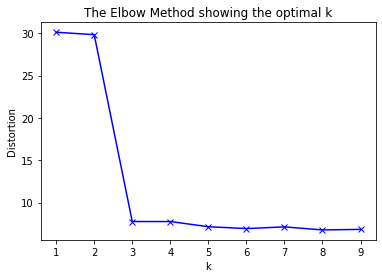

In [30]:
# Start with the Elblow medthod
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(bangkok_grouped_clustering)
    #kmeanModel.fit(istanbul_grouped_clustering)
    distortions.append(sum(np.min(cdist(bangkok_grouped_clustering, kmeanModel.cluster_centers_, 'canberra'), axis=1)) / bangkok_grouped_clustering.shape[0])

#There are different metric distance function for spatial distance. 
#I choose correlation instaed of euclidean because the canberra function gives me more clear view of elbow break point.

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

From the Elblow Method, it suggests us to use k = 3.

#### Next, Silhoette Method

In [31]:
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(init='k-means++', n_clusters=k, random_state=0).fit(bangkok_grouped_clustering)
    cluster_labels = kmeans.labels_
        
    silhouette_avg = silhouette_score(bangkok_grouped_clustering, cluster_labels)
    print(f"For n_clusters: {k}, average silhouette score: {silhouette_avg:.3f}")

For n_clusters: 2, average silhouette score: 0.220
For n_clusters: 3, average silhouette score: 0.251
For n_clusters: 4, average silhouette score: 0.168
For n_clusters: 5, average silhouette score: 0.219
For n_clusters: 6, average silhouette score: 0.214
For n_clusters: 7, average silhouette score: 0.156
For n_clusters: 8, average silhouette score: 0.192
For n_clusters: 9, average silhouette score: 0.157
For n_clusters: 10, average silhouette score: 0.152


From the Silhoette Method, the optimal k is 3. Since both two methods are consistent, we consider using k = 3.

#### Run k-means to cluster the neighborhood into 3 clusters.

In [32]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(init='k-means++', n_clusters=kclusters, random_state=0).fit(bangkok_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 1, 0, 1, 1, 1, 0, 1, 1, 0], dtype=int32)

#### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each district.

In [33]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bangkok_merged = bangkok_dist

# merge dataframes and grouped dataframe to add latitude/longitude for each district
bangkok_merged = bangkok_merged.join(neighborhoods_venues_sorted.set_index('District'), on='District')

bangkok_merged.head()

,District,Post-code,Popu-lation,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bang Bon,10150,105161,13.659200,100.399100,0,Noodle House,Thai Restaurant,Japanese Restaurant,Som Tum Restaurant,Asian Restaurant,Chinese Restaurant,Tonkatsu Restaurant,Udon Restaurant,Sushi Restaurant,Mediterranean Restaurant
1,Bang Kapi,10240,148465,13.765833,100.647778,1,Som Tum Restaurant,Japanese Restaurant,Noodle House,Fast Food Restaurant,Hotpot Restaurant,Thai Restaurant,Shabu-Shabu Restaurant,Ramen Restaurant,Sushi Restaurant,Korean Restaurant
2,Bang Khae,10160,191781,13.696111,100.409444,0,Noodle House,Japanese Restaurant,Fast Food Restaurant,Shabu-Shabu Restaurant,Asian Restaurant,Thai Restaurant,Sushi Restaurant,Tonkatsu Restaurant,Som Tum Restaurant,Mediterranean Restaurant
3,Bang Khen,10220,189539,13.873889,100.596389,1,Fast Food Restaurant,Hotpot Restaurant,Noodle House,Asian Restaurant,Vietnamese Restaurant,Som Tum Restaurant,Ramen Restaurant,Thai Restaurant,Shabu-Shabu Restaurant,Seafood Restaurant
4,Bang Kho Laem,10120,94956,13.693333,100.502500,1,Thai Restaurant,Noodle House,Chinese Restaurant,Seafood Restaurant,Vietnamese Restaurant,Asian Restaurant,Fast Food Restaurant,Som Tum Restaurant,Halal Restaurant,Hotpot Restaurant


In [34]:
bangkok_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   District                50 non-null     object 
 1   Post-code               50 non-null     int64  
 2   Popu-lation             50 non-null     int64  
 3   Latitude                50 non-null     float64
 4   Longitude               50 non-null     float64
 5   Cluster Labels          50 non-null     int32  
 6   1st Most Common Venue   50 non-null     object 
 7   2nd Most Common Venue   50 non-null     object 
 8   3rd Most Common Venue   50 non-null     object 
 9   4th Most Common Venue   50 non-null     object 
 10  5th Most Common Venue   50 non-null     object 
 11  6th Most Common Venue   50 non-null     object 
 12  7th Most Common Venue   50 non-null     object 
 13  8th Most Common Venue   50 non-null     object 
 14  9th Most Common Venue   50 non-null     obje

In [35]:
print(bangkok_merged.isnull().sum())

District                  0
Post-code                 0
Popu-lation               0
Latitude                  0
Longitude                 0
Cluster Labels            0
1st Most Common Venue     0
2nd Most Common Venue     0
3rd Most Common Venue     0
4th Most Common Venue     0
5th Most Common Venue     0
6th Most Common Venue     0
7th Most Common Venue     0
8th Most Common Venue     0
9th Most Common Venue     0
10th Most Common Venue    0
dtype: int64


#### We can also estimate the number of 1st Most Common Venue in each cluster.Thus, we can create a bar chart which may help us to find proper label names for each cluster.

In [36]:
count_venue = bangkok_merged
count_venue = count_venue.drop(['District','Post-code', 'Popu-lation', 'Latitude', 'Longitude'], axis=1)
count_venue = count_venue.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Counts')

#we can transpose it to plot bar chart
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st Most Common Venue,Chinese Restaurant,Fast Food Restaurant,Halal Restaurant,Japanese Restaurant,Noodle House,Som Tum Restaurant,Thai Restaurant
0,0,0,0,0,18,0,0
1,1,2,1,2,13,1,10
2,0,0,0,0,0,0,2


Text(0, 0.5, 'Number of Venue')

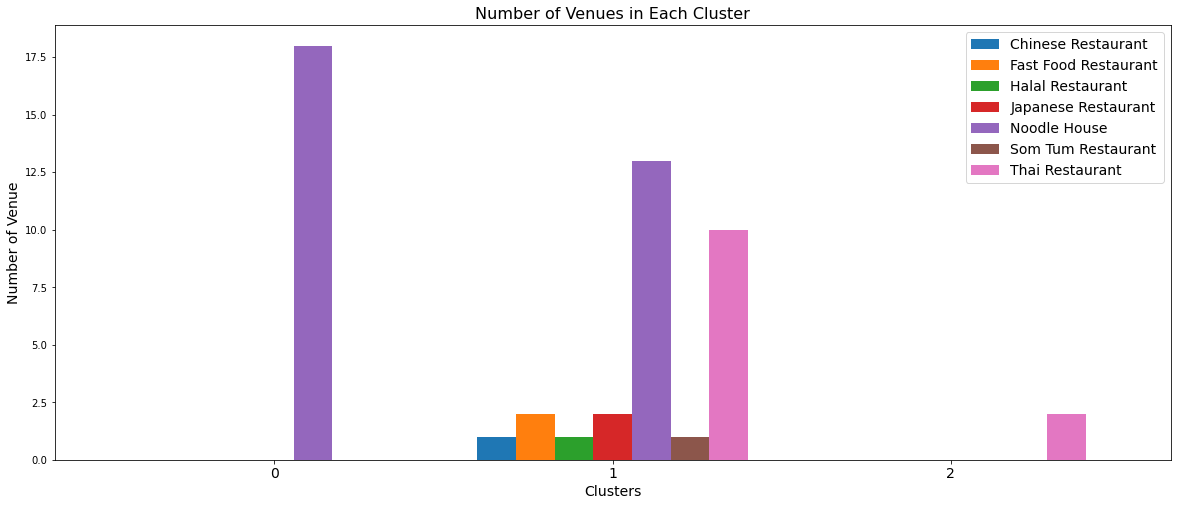

In [37]:
#creating a bar chart of "Number of Venues in Each Cluster"
frame=cv_cluster.plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=cv_cluster.columns,fontsize= 14)
plt.title("Number of Venues in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Clusters', fontsize=14)
plt.ylabel('Number of Venue', fontsize=14)

When we examine above graph we can label each cluster as follows:

* Cluster 0 : "Noodle House"
* Cluster 1 : "Multiple Types of Restaurant"
* Cluster 2 : "Thai Restaurant"

#### Finally, let's visualize the resulting clusters

In [38]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bangkok_merged['Latitude'], bangkok_merged['Longitude'], bangkok_merged['District'], bangkok_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine the Clusters

Examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, further derive these characteristics.

#### Cluster 1
Noodle House is predominantly prevalent in cluster 1. This is followed by a mix of either Thai or Asian restaurants.

In [39]:
bangkok_merged.loc[bangkok_merged['Cluster Labels'] == 0, bangkok_merged.columns[[0] + list(range(5, bangkok_merged.shape[1]))]]

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bang Bon,0,Noodle House,Thai Restaurant,Japanese Restaurant,Som Tum Restaurant,Asian Restaurant,Chinese Restaurant,Tonkatsu Restaurant,Udon Restaurant,Sushi Restaurant,Mediterranean Restaurant
2,Bang Khae,0,Noodle House,Japanese Restaurant,Fast Food Restaurant,Shabu-Shabu Restaurant,Asian Restaurant,Thai Restaurant,Sushi Restaurant,Tonkatsu Restaurant,Som Tum Restaurant,Mediterranean Restaurant
6,Bang Na,0,Noodle House,Asian Restaurant,Thai Restaurant,Chinese Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Ramen Restaurant,Satay Restaurant
9,Bang Sue,0,Noodle House,Thai Restaurant,Asian Restaurant,Fast Food Restaurant,Hotpot Restaurant,Japanese Restaurant,Shabu-Shabu Restaurant,Chinese Restaurant,Ramen Restaurant,Seafood Restaurant
10,Bangkok Noi,0,Noodle House,Som Tum Restaurant,Asian Restaurant,Shabu-Shabu Restaurant,Dim Sum Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Ramen Restaurant,Satay Restaurant,Seafood Restaurant
11,Bangkok Yai,0,Noodle House,Asian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Thai Restaurant,Seafood Restaurant,American Restaurant,Shabu-Shabu Restaurant,Middle Eastern Restaurant,Ramen Restaurant
15,Din Daeng,0,Noodle House,Thai Restaurant,Chinese Restaurant,Satay Restaurant,Seafood Restaurant,American Restaurant,Shabu-Shabu Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Ramen Restaurant
16,Don Mueang,0,Noodle House,Thai Restaurant,Seafood Restaurant,Chinese Restaurant,Som Tum Restaurant,American Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Ramen Restaurant,Satay Restaurant
17,Dusit,0,Noodle House,Thai Restaurant,Asian Restaurant,Som Tum Restaurant,Chinese Restaurant,Italian Restaurant,Vietnamese Restaurant,Shabu-Shabu Restaurant,Satay Restaurant,Middle Eastern Restaurant
22,Khlong Toei,0,Noodle House,Thai Restaurant,American Restaurant,Shabu-Shabu Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Ramen Restaurant,Satay Restaurant,Seafood Restaurant,Shanghai Restaurant


#### Cluster 2
Noodle House is predominantly prevalent in cluster 2. This is closely followed by restaurants offering asian-styled cuisine such as Thai, Chinese and Japanese.

In [40]:
bangkok_merged.loc[bangkok_merged['Cluster Labels'] == 1, bangkok_merged.columns[[0] + list(range(5, bangkok_merged.shape[1]))]]

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bang Kapi,1,Som Tum Restaurant,Japanese Restaurant,Noodle House,Fast Food Restaurant,Hotpot Restaurant,Thai Restaurant,Shabu-Shabu Restaurant,Ramen Restaurant,Sushi Restaurant,Korean Restaurant
3,Bang Khen,1,Fast Food Restaurant,Hotpot Restaurant,Noodle House,Asian Restaurant,Vietnamese Restaurant,Som Tum Restaurant,Ramen Restaurant,Thai Restaurant,Shabu-Shabu Restaurant,Seafood Restaurant
4,Bang Kho Laem,1,Thai Restaurant,Noodle House,Chinese Restaurant,Seafood Restaurant,Vietnamese Restaurant,Asian Restaurant,Fast Food Restaurant,Som Tum Restaurant,Halal Restaurant,Hotpot Restaurant
5,Bang Khun Thian,1,Thai Restaurant,Japanese Restaurant,Seafood Restaurant,Noodle House,Asian Restaurant,Hotpot Restaurant,Som Tum Restaurant,Fast Food Restaurant,Sushi Restaurant,Chinese Restaurant
7,Bang Phlat,1,Fast Food Restaurant,Japanese Restaurant,Ramen Restaurant,Thai Restaurant,Hotpot Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Middle Eastern Restaurant,Noodle House,Satay Restaurant
8,Bang Rak,1,Noodle House,Chinese Restaurant,Thai Restaurant,Seafood Restaurant,Japanese Restaurant,Ramen Restaurant,French Restaurant,Hotpot Restaurant,Shanghai Restaurant,Satay Restaurant
13,Chatuchak,1,Thai Restaurant,Japanese Restaurant,Fast Food Restaurant,Noodle House,Ramen Restaurant,Som Tum Restaurant,Shabu-Shabu Restaurant,Chinese Restaurant,Asian Restaurant,Japanese Curry Restaurant
18,Huai Khwang,1,Thai Restaurant,Noodle House,Japanese Restaurant,Asian Restaurant,Hotpot Restaurant,Chinese Restaurant,Som Tum Restaurant,Seafood Restaurant,Korean Restaurant,Shabu-Shabu Restaurant
19,Khan Na Yao,1,Japanese Restaurant,Thai Restaurant,Noodle House,Som Tum Restaurant,Hotpot Restaurant,Sushi Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Japanese Curry Restaurant,Ramen Restaurant
20,Khlong Sam Wa,1,Noodle House,Thai Restaurant,Japanese Restaurant,Chinese Restaurant,French Restaurant,Shabu-Shabu Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Fast Food Restaurant,Dumpling Restaurant


#### Cluster 3
Thai restaurant is predominantly prevalent in cluster 3. This is followed by a American and Asian restaurants.

In [41]:
bangkok_merged.loc[bangkok_merged['Cluster Labels'] == 2, bangkok_merged.columns[[0] + list(range(5, bangkok_merged.shape[1]))]]

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Bueng Kum,2,Thai Restaurant,American Restaurant,Shabu-Shabu Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Noodle House,Ramen Restaurant,Satay Restaurant,Seafood Restaurant,Shanghai Restaurant
14,Chom Thong,2,Thai Restaurant,Asian Restaurant,Seafood Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Noodle House,Ramen Restaurant,Satay Restaurant,American Restaurant


### Recommendations

Exploring the districts in Bangkok, Bang Kapi, Sathon, Bang Rak, Pathum Wan, Yan Nawa and Huai Khwang have higher density of restuarants (more than 40 in its area). 
The higher restaurant density could imply these areas as being more popular with visitors with more tourist attractions in their vicinities.

Preliminary recommended locations are Bangkok Noi and Sathon for market entry.

**Bangkok Noi** is assigned to **cluster 1**; a restaurant offering **Noodles** could have a higher chance of success with the visitors.

**Sathon** is assigned to **cluster 1**; a restaurant offering **Noodles** could have a higher chance of success with the visitors.


Regardless of above recommendations, the other fundamentals of F&B service such as quality food & services and strict hygiene practices are not to be overlooked.
